CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.89MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
SEED = 1
batch_size = 32
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


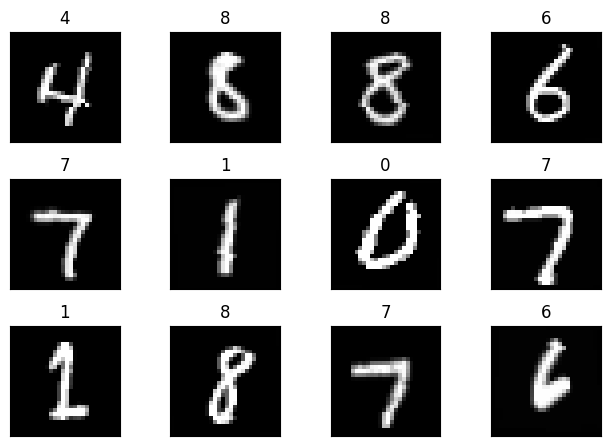

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.Conv2d(10, 10, 3),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 15, 3),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value),
            nn.Conv2d(15, 20, 3),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(20, 10, 3),
            nn.BatchNorm2d(10)
        )
        self.gap = nn.AvgPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.flatten().view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

| Layer                         | Rin  | Rout | Jin  | Jout |
|-------------------------------|-------|------|------|------|
| **Input Image (28x28)**       | 1     | 1    | 1    | 1    |
| **Conv Block 1**              |       |      |      |      |
| Conv2d(1, 8, K=3, P=0, S=1)   | 1     | 3    | 1    | 1    |
| Conv2d(8, 8, K=3, P=0, S=1)   | 3     | 5    | 1    | 1    |
| MaxPool2d(K=2, S=2)           | 5     | 6    | 1    | 2    |
| **Conv Block 2**              |       |      |      |      |
| Conv2d(8, 16, K=3, P=0, S=1)  | 6     | 10   | 2    | 2    |
| Conv2d(16, 16, K=3, P=0, S=1) | 10    | 14   | 2    | 2    |
| MaxPool2d(K=2, S=2)           | 14    | 16   | 2    | 4    |
| **Conv Block 3**              |       |      |      |      |
| Conv2d(16, 10, K=3, P=0, S=1) | 16    | 24   | 4    | 4    |
| AvgPool2d(K=2, S=2)           | 24    | 26   | 4    | 8    |
| **GAP (Global Avg Pool)**     | 26    | Full | 8    | -    |


In [ ]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             910
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
             ReLU-10           [-1, 10, 12, 12]               0
          Dropout-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,365
             ReLU-13           [-1, 15, 10, 10]               0
      BatchNorm2d-14           [-1, 15,

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred,  target.squeeze())
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)

Epoch 1


Train: Loss=0.0466 Batch_id=1874 Accuracy=94.91: 100%|██████████| 1875/1875 [01:01<00:00, 30.49it/s]


Test set: Average loss: 0.0013, Accuracy: 9872/10000 (98.72%)

Epoch 2


Train: Loss=0.2466 Batch_id=1874 Accuracy=97.14: 100%|██████████| 1875/1875 [01:02<00:00, 30.08it/s]


Test set: Average loss: 0.0014, Accuracy: 9875/10000 (98.75%)

Epoch 3


Train: Loss=0.2104 Batch_id=1874 Accuracy=97.66: 100%|██████████| 1875/1875 [01:01<00:00, 30.47it/s]


Test set: Average loss: 0.0009, Accuracy: 9904/10000 (99.04%)

Epoch 4


Train: Loss=0.0050 Batch_id=1874 Accuracy=97.79: 100%|██████████| 1875/1875 [01:01<00:00, 30.42it/s]


Test set: Average loss: 0.0009, Accuracy: 9904/10000 (99.04%)

Epoch 5


Train: Loss=0.1226 Batch_id=1874 Accuracy=97.97: 100%|██████████| 1875/1875 [01:01<00:00, 30.59it/s]


Test set: Average loss: 0.0008, Accuracy: 9912/10000 (99.12%)

Epoch 6


Train: Loss=0.0045 Batch_id=1874 Accuracy=98.10: 100%|██████████| 1875/1875 [01:01<00:00, 30.37it/s]


Test set: Average loss: 0.0008, Accuracy: 9907/10000 (99.07%)

Epoch 7


Train: Loss=0.0204 Batch_id=1874 Accuracy=98.19: 100%|██████████| 1875/1875 [01:00<00:00, 30.86it/s]


Test set: Average loss: 0.0007, Accuracy: 9924/10000 (99.24%)

Epoch 8


Train: Loss=0.0109 Batch_id=1874 Accuracy=98.17: 100%|██████████| 1875/1875 [01:00<00:00, 31.02it/s]


Test set: Average loss: 0.0007, Accuracy: 9925/10000 (99.25%)

Epoch 9


Train: Loss=0.0058 Batch_id=1874 Accuracy=98.29: 100%|██████████| 1875/1875 [01:02<00:00, 29.84it/s]


Test set: Average loss: 0.0008, Accuracy: 9918/10000 (99.18%)

Epoch 10


Train: Loss=0.0164 Batch_id=1874 Accuracy=98.33: 100%|██████████| 1875/1875 [01:00<00:00, 31.11it/s]


Test set: Average loss: 0.0007, Accuracy: 9928/10000 (99.28%)

Epoch 11


Train: Loss=0.0154 Batch_id=1874 Accuracy=98.41: 100%|██████████| 1875/1875 [01:01<00:00, 30.50it/s]


Test set: Average loss: 0.0007, Accuracy: 9930/10000 (99.30%)

Epoch 12


Train: Loss=0.0641 Batch_id=1874 Accuracy=98.46: 100%|██████████| 1875/1875 [01:01<00:00, 30.42it/s]


Test set: Average loss: 0.0007, Accuracy: 9934/10000 (99.34%)

Epoch 13


Train: Loss=0.1961 Batch_id=1874 Accuracy=98.57: 100%|██████████| 1875/1875 [01:01<00:00, 30.69it/s]


Test set: Average loss: 0.0006, Accuracy: 9937/10000 (99.37%)

Epoch 14


Train: Loss=0.0035 Batch_id=1874 Accuracy=98.54: 100%|██████████| 1875/1875 [01:00<00:00, 30.84it/s]


Test set: Average loss: 0.0007, Accuracy: 9928/10000 (99.28%)

Epoch 15


Train: Loss=0.0034 Batch_id=1874 Accuracy=98.54: 100%|██████████| 1875/1875 [01:01<00:00, 30.34it/s]


Test set: Average loss: 0.0006, Accuracy: 9935/10000 (99.35%)

Epoch 16


Train: Loss=0.0073 Batch_id=1874 Accuracy=98.43: 100%|██████████| 1875/1875 [01:01<00:00, 30.55it/s]


Test set: Average loss: 0.0007, Accuracy: 9925/10000 (99.25%)

Epoch 17


Train: Loss=0.0277 Batch_id=1874 Accuracy=98.52: 100%|██████████| 1875/1875 [00:59<00:00, 31.27it/s]


Test set: Average loss: 0.0006, Accuracy: 9931/10000 (99.31%)

Epoch 18


Train: Loss=0.0648 Batch_id=1874 Accuracy=98.60: 100%|██████████| 1875/1875 [01:02<00:00, 29.92it/s]


Test set: Average loss: 0.0006, Accuracy: 9938/10000 (99.38%)

Epoch 19


Train: Loss=0.1053 Batch_id=1874 Accuracy=98.58: 100%|██████████| 1875/1875 [01:00<00:00, 31.20it/s]


Test set: Average loss: 0.0006, Accuracy: 9937/10000 (99.37%)

Epoch 20


Train: Loss=0.0164 Batch_id=1623 Accuracy=98.67:  86%|████████▋ | 1621/1875 [00:52<00:06, 36.74it/s]